In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import random
import csv
import math
import statistics
import os
import os.path
from os import path
import time

random.seed(1)
np.random.seed(1)

In [2]:
# set home dir
os.chdir('..//..//')
os.getcwd();

In [3]:
# Out_dir is where you want all of the program output to be. The code will make subfolders for you nicely!
out_dir = 'other'
# Data_dir is where all of the stock data is
data_dir = "Data//Stocks_Sector_CC"

days_total = 80
window_size = 15
num_iter_test = 100

num_tasks = 45
epochs = 1000
# Should be 1 for meta-learning
num_iter_meta = 1

sample_size = 10

days_train = int(days_total * 0.7)

In [4]:
def writeCSV(directory, out_type, data):
    identifier = '_e_{}_t_{}_im_{}_it_{}_d_{}_w_{}'
    ident_fill = identifier.format(epochs,num_tasks,num_iter_meta,num_iter_test,days_total,window_size)
    
    # Create subfolders and assign variables based on output type
    if(out_type in ["meta_data","train_data","profit_data","results_data"]):
        if(out_type == "meta_data"):
            folder = out_dir + "/meta"
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Epoch","Reward"]
       
        if(out_type == "results_data"):
            folder = out_dir + "/final_results"
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Sample","Total Profit"]

        if(out_type == "train_data"):
            folder = (out_dir 
                      + "/trading_stats/" 
                      + "trading" 
                      + ident_fill 
                      + '/train')
            if(not path.exists(out_dir + "/trading_stats")):    
                os.mkdir(out_dir + "/trading_stats")
            if(not path.exists(out_dir + "/trading_stats/trading" + ident_fill)):    
                os.mkdir(out_dir + "/trading_stats/trading" + ident_fill)
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Iteration","Reward"]

        if(out_type == "profit_data"):
            folder = (out_dir + "/trading_stats/" + "trading" + ident_fill + '/trade_balance')
            if(not path.exists(out_dir + "/trading_stats")):    
                os.mkdir(out_dir + "/trading_stats")
            if(not path.exists(out_dir + "/trading_stats/trading" + ident_fill)):    
                os.mkdir(out_dir + "/trading_stats/trading" + ident_fill)
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Day","Profit"]
            
        fileName = (folder + '/' + out_type + ident_fill + " - {}.csv")
        
        # Save file with incremented ending
        i = 1
        while(path.exists(fileName.format(i))):
            i += 1
        saveFile = fileName.format(i)
        
        # Write to csv file with cols as headers, integer indicies, and data
        with open(saveFile, mode='x', newline='') as test_file:
            test_writer = csv.writer(test_file, delimiter=',', quotechar='\"', quoting=csv.QUOTE_MINIMAL)
            test_writer.writerow(cols)
            for i,j in zip(data,range(0, len(data))):
                test_writer.writerow([str(j), str(i)])
        test_file.close()

    else:
        raise Exception('\'' 
                        + out_type 
                        + '\' was not one of the options:\n' 
                        + '\'meta_data\'\n' 
                        + '\'train_data\'\n' 
                        + '\'profit_data\'\n'
                        + '\'results_data\'\n')

    
def saveFig(directory, out_type):
    identifier = '_e_{}_t_{}_im_{}_it_{}_d_{}_w_{}'
    ident_fill = identifier.format(epochs,num_tasks,num_iter_meta,num_iter_test,days_total,window_size)
    
    # Make folders in out_dir and set paths
    folder_final_results = directory + '/final_results' 
    folder_meta = directory + '/meta'
    folder_trading_stats = directory + '/trading_stats'
    if(not path.exists(folder_final_results)):
        os.mkdir(folder_final_results)
    if(not path.exists(folder_meta)):
        os.mkdir(folder_meta)
    if(not path.exists(folder_trading_stats)):
        os.mkdir(folder_trading_stats)
    
    trade_path = folder_trading_stats + '/' + 'trading' + ident_fill
    trade_path2 = trade_path + '/' + out_type    
    
    # Add files to folders
    filename = ""
    
    if(out_type in ['trading','trade_balance','test_stock', 'train']):
        if(not path.exists(trade_path)):
            os.mkdir(trade_path)
        if(out_type != 'test_stock'):
            if(not path.exists(trade_path2)):
                os.mkdir(trade_path2)
            fileName = trade_path2 + '/' + out_type + ident_fill    
        
        elif(out_type == 'test_stock'):
            fileName = trade_path + '/' + out_type + ident_fill
            
    elif(out_type == 'meta'):
        fileName = folder_meta + '/' + out_type + ident_fill
       
    elif(out_type == 'results'):
        fileName = folder_final_results + '/' + out_type + ident_fill
    
    else:
        raise Exception('\'' 
                        + out_type 
                        + '\' was not one of the options:\n' 
                        + '\'meta\'\n' 
                        + '\'results\'\n' 
                        + '\'trading\'\n' 
                        + '\'trade_balance\'\n' 
                        + '\'out_typeset\'\n' 
                        + '\'train\'\n')
    
    filename = filename + ' - {}.png'
    i = 1
    while(path.exists(fileName.format(i))):
        i += 1
    plt.savefig(fileName.format(i))

In [5]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[: t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [6]:
class Deep_Evolution_Strategy:
    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
                
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 0.0001)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])                   
                
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * (np.dot(A.T, rewards).T + 0.0001)
                )
                
            epoch_rewards.append(self.reward_function(self.weights))

In [7]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [8]:
import time

class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.3
    LEARNING_RATE = 0.03

    def __init__(
        self, model, money, max_buy, max_sell, close, window_size, skip
    ):
        self.profit = 0
        
        self.window_size = window_size
        self.skip = skip
        self.close = close
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )
        
    def get_profit(self):
        return self.profit
    
    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):        
        initial_money = self.initial_money
        starting_money = initial_money
        len_close = len(self.close) - 1

        self.model.weights = weights
        state = get_state(self.close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy                
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity                
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell
            state = next_state
        return ((initial_money - starting_money) / (starting_money + 0.0001)) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
       
        initial_money = self.initial_money
        len_close = len(self.close) - 1
        state = get_state(self.close, 0, self.window_size + 1)
        starting_money = initial_money
        track_money.append(initial_money - starting_money)
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, len_close, self.skip):
            
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
                
                track_money.append(initial_money - starting_money)
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
                track_money.append(initial_money - starting_money)
                
            else:
                track_money.append(initial_money - starting_money)
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        
        self.profit = initial_money - starting_money
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        
        plt.figure(figsize = (20, 10))
        plt.title("Trading")
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        saveFig(out_dir, 'trading')
        plt.show()


In [9]:
# Retrieve datasets
datasetNames = []
allDatasets = []
for root,dirs,files in os.walk(data_dir):
    for file in files:
        if file.endswith("_New.csv"):
            datasetNames.append(file)
            dataset = pd.read_csv(data_dir + "\\" + file)
            allDatasets.append((file,dataset[:days_total]))

#sSet up model
input_size_g = window_size
layer_size_g = 500
output_size_g = 3
model = Model(input_size = input_size_g, layer_size = layer_size_g, output_size = output_size_g)

#initialize meta-weights as random
feed_w1 = np.random.randn(input_size_g, layer_size_g)
decision_w2 = np.random.randn(layer_size_g, output_size_g)
buy_w3 = np.random.randn(layer_size_g, 1)
feed_w4 = np.random.randn(1, layer_size_g)

In [10]:
# Pick datasets that start at Jan 2, 2001
datasets = []
for i in allDatasets:
    if(i[1]["Unnamed: 0"][0] == '1/2/2001'):
        datasets.append(i)
    else:
        print("Excluded from dataset:",i[0])
        
if(num_tasks > (len(datasets) - 1)):
    raise Exception('num_tasks = ' + str(num_tasks) + ', but there are only ' + str(len(datasets)) + ' datasets!')

Excluded from dataset: DG_New.csv
Excluded from dataset: NLSN_New.csv
Excluded from dataset: PFG_New.csv
Excluded from dataset: PM_New.csv
Excluded from dataset: TDC_New.csv


In [11]:
meta_datasets = datasets[:num_tasks]
epoch_rewards = []
avg_rewards = []
times = []
# Learning rate
epsilon = 0.1

for e in range(epochs):
    # For each dataset
    start_time = int(round(time.time() * 1000))
    for task in range(num_tasks):
        # Retrieve stock closing prices
        close = meta_datasets[task][1].Close.values.tolist()[:days_train]
        # Set meta_weights
        old_w1, old_w2, old_w3, old_w4 = [feed_w1, decision_w2, buy_w3, feed_w4]
        
        agent = Agent(
            model = model,
            money = 10000,
            max_buy = 5,
            max_sell = 5,
            close = close,
            window_size = window_size,
            skip = 1,
        )
        
        # Train with only 1 iteration (for meta-learning)
        agent.fit(iterations = num_iter_meta, checkpoint = 1)
        
        # Get task specific model weights
        new_w1, new_w2, new_w3, new_w4 = model.get_weights()
        
        # Get updated meta-weights
        updated_w1 = old_w1 + epsilon * (new_w1 - old_w1) 
        updated_w2 = old_w2 + epsilon * (new_w2 - old_w2)
        updated_w3 = old_w3 + epsilon * (new_w3 - old_w3) 
        updated_w4 = old_w4 + epsilon * (new_w4 - old_w4)
        
        # Update meta-weights
        feed_w1 =  updated_w1
        decision_w2 = updated_w2
        buy_w3 = updated_w3
        feed_w4 = updated_w4
        
        # Update model with new updated meta-weights
        model.set_weights([feed_w1, decision_w2, buy_w3, feed_w4])
    
    # Collect average rewards for each epoch
    avg_rewards.append(statistics.mean(epoch_rewards))  
    epoch_rewards = []
    
    end_time = int(round(time.time() * 1000))
    runtime = end_time - start_time
    if(len(times) < 2):
        times = [runtime] + times
    else:
        times = [runtime] + times
        times.pop()
        
    perc = round((e/epochs) * 100, 2)
    est_time = round((epochs - e) * statistics.mean(times) / 1000)
    print(str(perc) + "%\te: " + str(e) + "\tETA: " + str(est_time/60) + " min")
    

writeCSV(out_dir,"meta_data",avg_rewards)

0.0%	e: 0	ETA: 25.816666666666666 min
0.1%	e: 1	ETA: 25.083333333333332 min
0.2%	e: 2	ETA: 31.0 min
0.3%	e: 3	ETA: 38.93333333333333 min
0.4%	e: 4	ETA: 38.63333333333333 min
0.5%	e: 5	ETA: 33.96666666666667 min
0.6%	e: 6	ETA: 33.03333333333333 min
0.7%	e: 7	ETA: 32.56666666666667 min
0.8%	e: 8	ETA: 29.733333333333334 min
0.9%	e: 9	ETA: 29.966666666666665 min
1.0%	e: 10	ETA: 31.066666666666666 min
1.1%	e: 11	ETA: 35.0 min
1.2%	e: 12	ETA: 37.38333333333333 min
1.3%	e: 13	ETA: 36.266666666666666 min
1.4%	e: 14	ETA: 37.8 min
1.5%	e: 15	ETA: 37.8 min
1.6%	e: 16	ETA: 45.35 min
1.7%	e: 17	ETA: 45.11666666666667 min
1.8%	e: 18	ETA: 35.86666666666667 min
1.9%	e: 19	ETA: 36.083333333333336 min
2.0%	e: 20	ETA: 36.36666666666667 min
2.1%	e: 21	ETA: 36.0 min
2.2%	e: 22	ETA: 35.766666666666666 min
2.3%	e: 23	ETA: 34.96666666666667 min
2.4%	e: 24	ETA: 33.63333333333333 min
2.5%	e: 25	ETA: 33.81666666666667 min
2.6%	e: 26	ETA: 34.38333333333333 min
2.7%	e: 27	ETA: 34.833333333333336 min
2.8%	e: 28	ETA

23.2%	e: 232	ETA: 30.65 min
23.3%	e: 233	ETA: 41.06666666666667 min
23.4%	e: 234	ETA: 41.06666666666667 min
23.5%	e: 235	ETA: 40.68333333333333 min
23.6%	e: 236	ETA: 41.38333333333333 min
23.7%	e: 237	ETA: 40.483333333333334 min
23.8%	e: 238	ETA: 39.03333333333333 min
23.9%	e: 239	ETA: 37.43333333333333 min
24.0%	e: 240	ETA: 36.75 min
24.1%	e: 241	ETA: 35.36666666666667 min
24.2%	e: 242	ETA: 30.8 min
24.3%	e: 243	ETA: 27.966666666666665 min
24.4%	e: 244	ETA: 27.933333333333334 min
24.5%	e: 245	ETA: 28.166666666666668 min
24.6%	e: 246	ETA: 27.966666666666665 min
24.7%	e: 247	ETA: 27.983333333333334 min
24.8%	e: 248	ETA: 28.433333333333334 min
24.9%	e: 249	ETA: 28.566666666666666 min
25.0%	e: 250	ETA: 27.983333333333334 min
25.1%	e: 251	ETA: 27.45 min
25.2%	e: 252	ETA: 27.216666666666665 min
25.3%	e: 253	ETA: 27.6 min
25.4%	e: 254	ETA: 28.133333333333333 min
25.5%	e: 255	ETA: 27.933333333333334 min
25.6%	e: 256	ETA: 27.366666666666667 min
25.7%	e: 257	ETA: 27.066666666666666 min
25.8%	e:

45.4%	e: 454	ETA: 19.733333333333334 min
45.5%	e: 455	ETA: 20.5 min
45.6%	e: 456	ETA: 19.983333333333334 min
45.7%	e: 457	ETA: 19.45 min
45.8%	e: 458	ETA: 19.466666666666665 min
45.9%	e: 459	ETA: 19.316666666666666 min
46.0%	e: 460	ETA: 19.666666666666668 min
46.1%	e: 461	ETA: 20.133333333333333 min
46.2%	e: 462	ETA: 20.016666666666666 min
46.3%	e: 463	ETA: 19.833333333333332 min
46.4%	e: 464	ETA: 20.3 min
46.5%	e: 465	ETA: 20.016666666666666 min
46.6%	e: 466	ETA: 19.533333333333335 min
46.7%	e: 467	ETA: 19.4 min
46.8%	e: 468	ETA: 19.25 min
46.9%	e: 469	ETA: 19.566666666666666 min
47.0%	e: 470	ETA: 19.75 min
47.1%	e: 471	ETA: 19.266666666666666 min
47.2%	e: 472	ETA: 18.816666666666666 min
47.3%	e: 473	ETA: 18.85 min
47.4%	e: 474	ETA: 19.05 min
47.5%	e: 475	ETA: 19.233333333333334 min
47.6%	e: 476	ETA: 19.383333333333333 min
47.7%	e: 477	ETA: 19.433333333333334 min
47.8%	e: 478	ETA: 19.666666666666668 min
47.9%	e: 479	ETA: 19.433333333333334 min
48.0%	e: 480	ETA: 19.0 min
48.1%	e: 481	E

68.1%	e: 681	ETA: 11.633333333333333 min
68.2%	e: 682	ETA: 11.616666666666667 min
68.3%	e: 683	ETA: 11.733333333333333 min
68.4%	e: 684	ETA: 11.516666666666667 min
68.5%	e: 685	ETA: 11.533333333333333 min
68.6%	e: 686	ETA: 11.816666666666666 min
68.7%	e: 687	ETA: 11.666666666666666 min
68.8%	e: 688	ETA: 11.45 min
68.9%	e: 689	ETA: 11.416666666666666 min
69.0%	e: 690	ETA: 11.45 min
69.1%	e: 691	ETA: 11.233333333333333 min
69.2%	e: 692	ETA: 11.116666666666667 min
69.3%	e: 693	ETA: 11.083333333333334 min
69.4%	e: 694	ETA: 11.216666666666667 min
69.5%	e: 695	ETA: 11.283333333333333 min
69.6%	e: 696	ETA: 11.116666666666667 min
69.7%	e: 697	ETA: 11.0 min
69.8%	e: 698	ETA: 10.916666666666666 min
69.9%	e: 699	ETA: 11.216666666666667 min
70.0%	e: 700	ETA: 11.25 min
70.1%	e: 701	ETA: 11.083333333333334 min
70.2%	e: 702	ETA: 10.95 min
70.3%	e: 703	ETA: 10.816666666666666 min
70.4%	e: 704	ETA: 10.866666666666667 min
70.5%	e: 705	ETA: 9.833333333333334 min
70.6%	e: 706	ETA: 7.516666666666667 min
70

91.0%	e: 910	ETA: 3.3833333333333333 min
91.1%	e: 911	ETA: 3.316666666666667 min
91.2%	e: 912	ETA: 3.216666666666667 min
91.3%	e: 913	ETA: 3.183333333333333 min
91.4%	e: 914	ETA: 3.216666666666667 min
91.5%	e: 915	ETA: 3.1333333333333333 min
91.6%	e: 916	ETA: 3.0 min
91.7%	e: 917	ETA: 2.9833333333333334 min
91.8%	e: 918	ETA: 2.966666666666667 min
91.9%	e: 919	ETA: 2.966666666666667 min
92.0%	e: 920	ETA: 2.9833333333333334 min
92.1%	e: 921	ETA: 2.966666666666667 min
92.2%	e: 922	ETA: 2.933333333333333 min
92.3%	e: 923	ETA: 2.8333333333333335 min
92.4%	e: 924	ETA: 2.783333333333333 min
92.5%	e: 925	ETA: 2.8333333333333335 min
92.6%	e: 926	ETA: 2.85 min
92.7%	e: 927	ETA: 2.75 min
92.8%	e: 928	ETA: 2.6333333333333333 min
92.9%	e: 929	ETA: 2.65 min
93.0%	e: 930	ETA: 2.6 min
93.1%	e: 931	ETA: 2.533333333333333 min
93.2%	e: 932	ETA: 2.5166666666666666 min
93.3%	e: 933	ETA: 2.466666666666667 min
93.4%	e: 934	ETA: 2.3666666666666667 min
93.5%	e: 935	ETA: 2.316666666666667 min
93.6%	e: 936	ETA: 

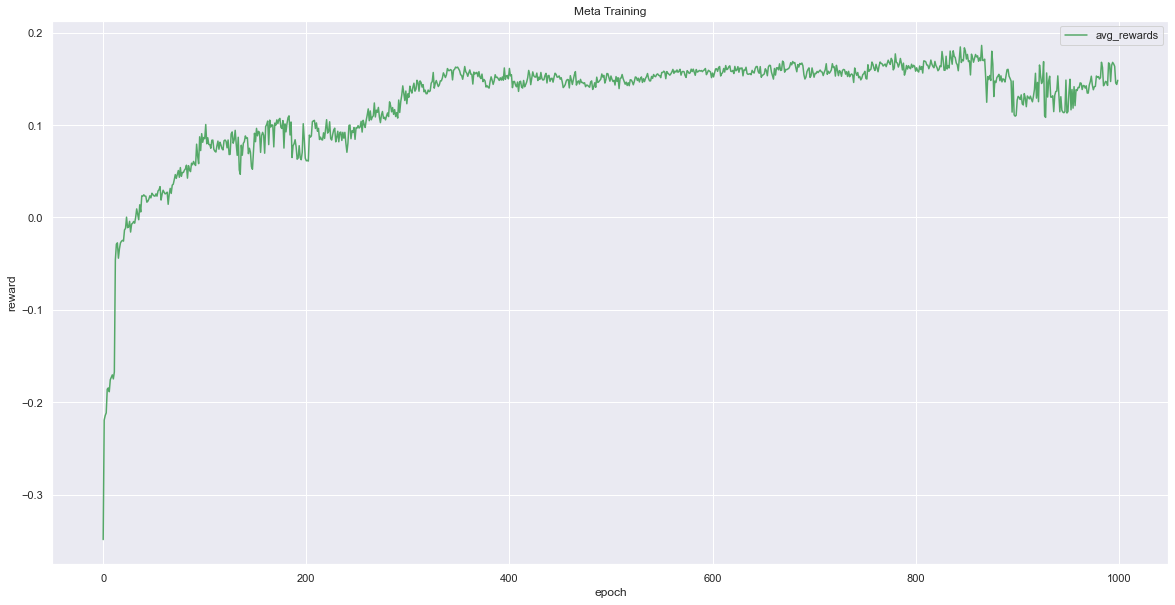

In [12]:
# Meta training plot
plt.figure(figsize = (20, 10))
plt.title("Meta Training")
plt.xlabel('epoch')
plt.ylabel('reward')
plt.plot(avg_rewards, label = 'avg_rewards', c = 'g')
plt.ticklabel_format(style='plain')
plt.legend()

saveFig(out_dir, 'meta')
plt.show()

In [13]:
days_total - days_train

24

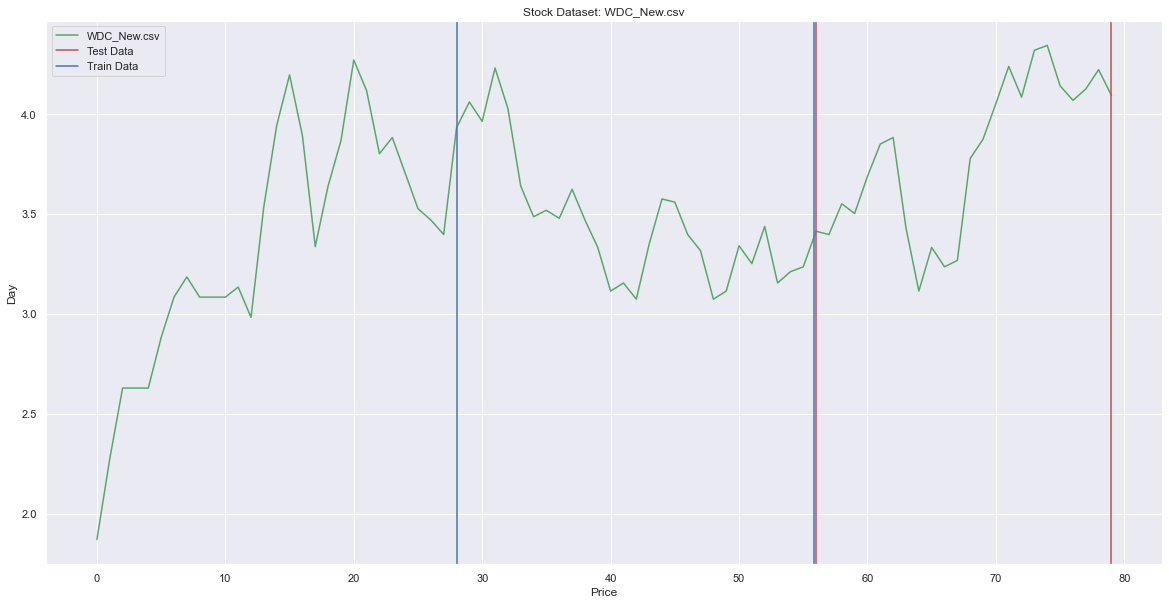

In [14]:
days_test = days_total - days_train
half = int(days_train / 2)

# Split test stage into train and test
test = datasets[-1]
test_dataset = datasets[-1][1]
t_train = test_dataset[half:days_train] 
t_test = test_dataset[days_train:days_total]

c = test_dataset.Close.values.tolist()

# Test stock plot
plt.figure(figsize = (20, 10))
plt.title("Stock Dataset: " + test[0])
plt.xlabel('Price')
plt.ylabel('Day')
plt.plot(c, label = test[0], c = 'g')
plt.axvline(x=days_train, label = 'Test Data', color = 'r')
plt.axvline(x=days_total-1, color = 'r')
plt.axvline(x=half, label = 'Train Data', color = 'b')
plt.axvline(x=days_train - 0.2, color = 'b')
plt.ticklabel_format(style='plain')
plt.legend()
saveFig(out_dir, 'test_stock')
plt.show()

day 8: buy 5 units at price 15.570855, total balance 9984.429145
day 9: buy 1 units at price 3.332568, total balance 9981.096577
day 10: buy 1 units at price 3.235503, total balance 9977.861074
day 11, sell 5 units at price 16.339290, investment 4.935085 %, total balance 9994.200364,
day 12, sell 2 units at price 7.554900, investment 126.699050 %, total balance 10001.755264,
day 16: buy 5 units at price 20.424110, total balance 9981.331154
day 17: buy 5 units at price 21.596980, total balance 9959.734174
day 18: buy 5 units at price 21.718315, total balance 9938.015859
day 19: buy 5 units at price 20.707215, total balance 9917.308644
day 20, sell 5 units at price 20.343220, investment -0.396052 %, total balance 9937.651864,
day 21: buy 3 units at price 12.375792, total balance 9925.276072
day 22, sell 5 units at price 21.111655, investment -2.247189 %, total balance 9946.387727,

total gained -53.612273, total investment -0.536123 %


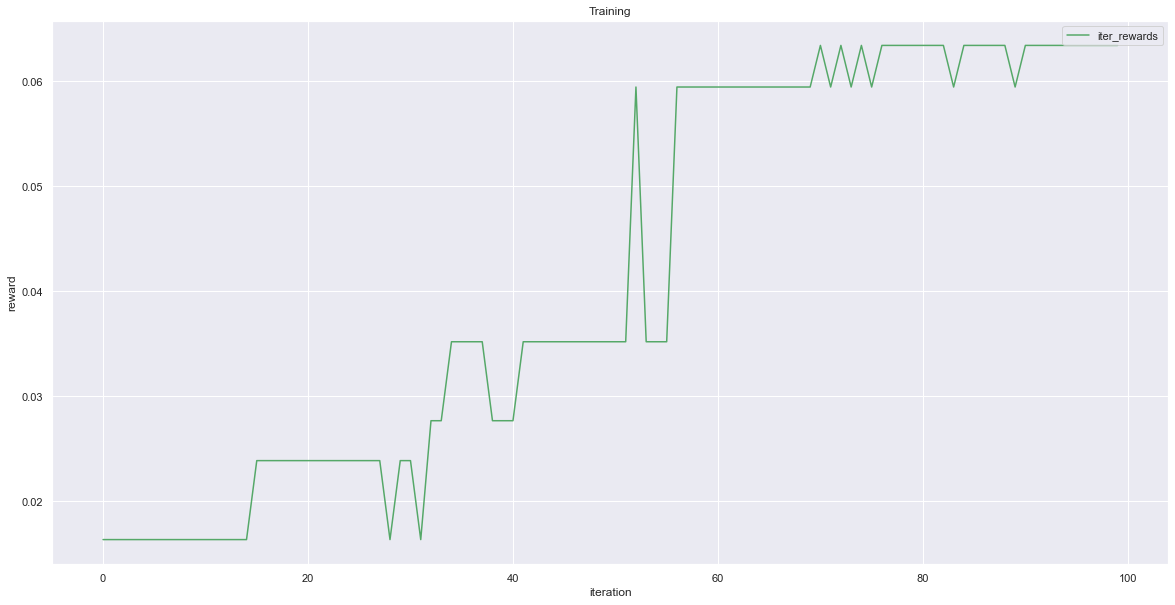

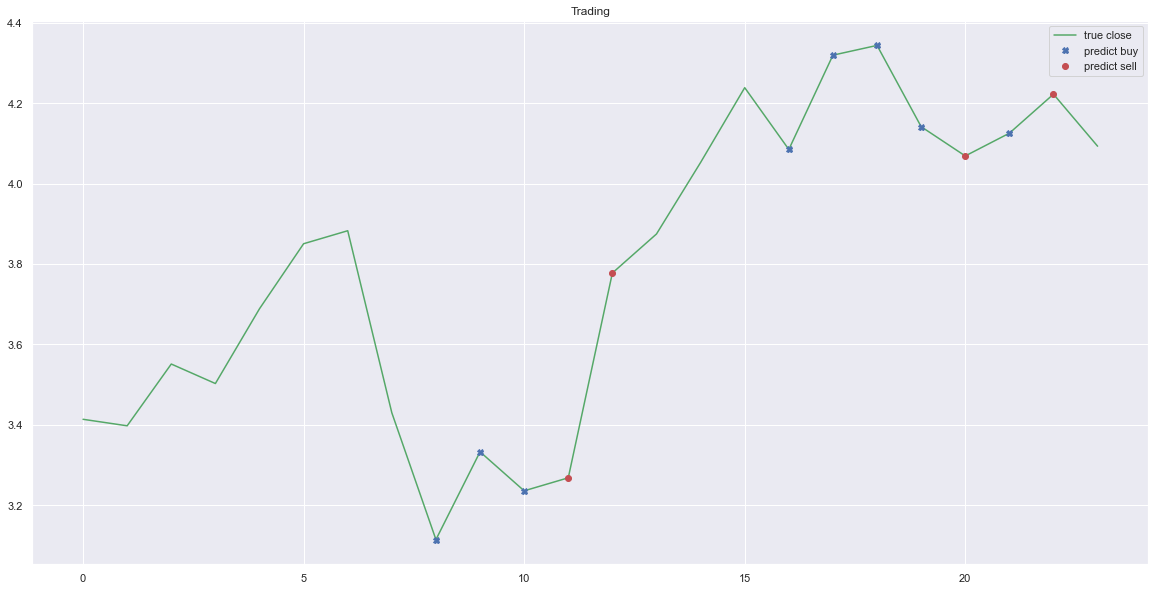

day 8: buy 5 units at price 15.570855, total balance 9984.429145
day 9: buy 1 units at price 3.332568, total balance 9981.096577
day 10, sell 5 units at price 16.177515, investment 3.896125 %, total balance 9997.274092,
day 11, sell 1 units at price 3.267858, investment -1.941746 %, total balance 10000.541950,
day 16: buy 5 units at price 20.424110, total balance 9980.117840
day 17: buy 5 units at price 21.596980, total balance 9958.520860
day 18: buy 5 units at price 21.718315, total balance 9936.802545
day 19, sell 5 units at price 20.707215, investment 1.386131 %, total balance 9957.509760,
day 20, sell 5 units at price 20.343220, investment -5.805256 %, total balance 9977.852980,
day 21: buy 1 units at price 4.125264, total balance 9973.727716
day 22, sell 5 units at price 21.111655, investment -2.793311 %, total balance 9994.839371,

total gained -5.160629, total investment -0.051606 %


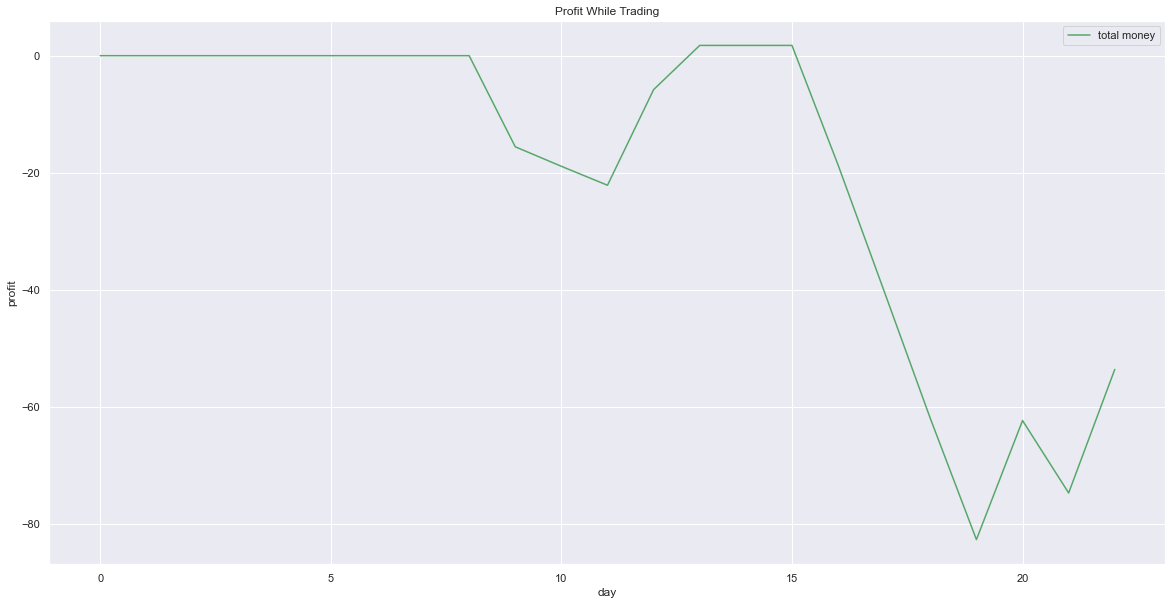

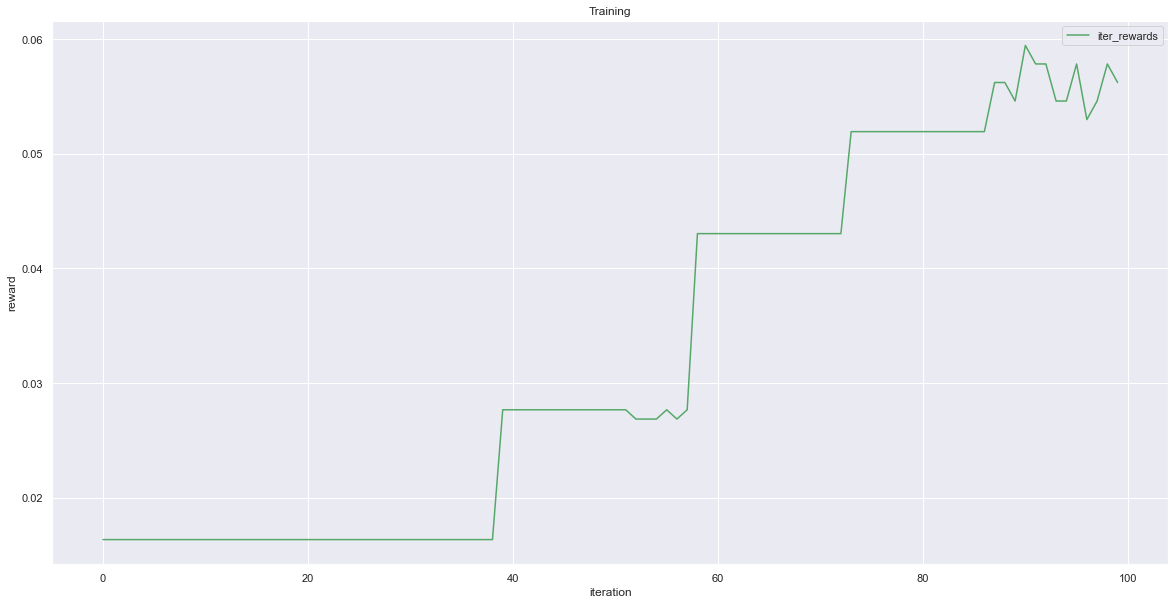

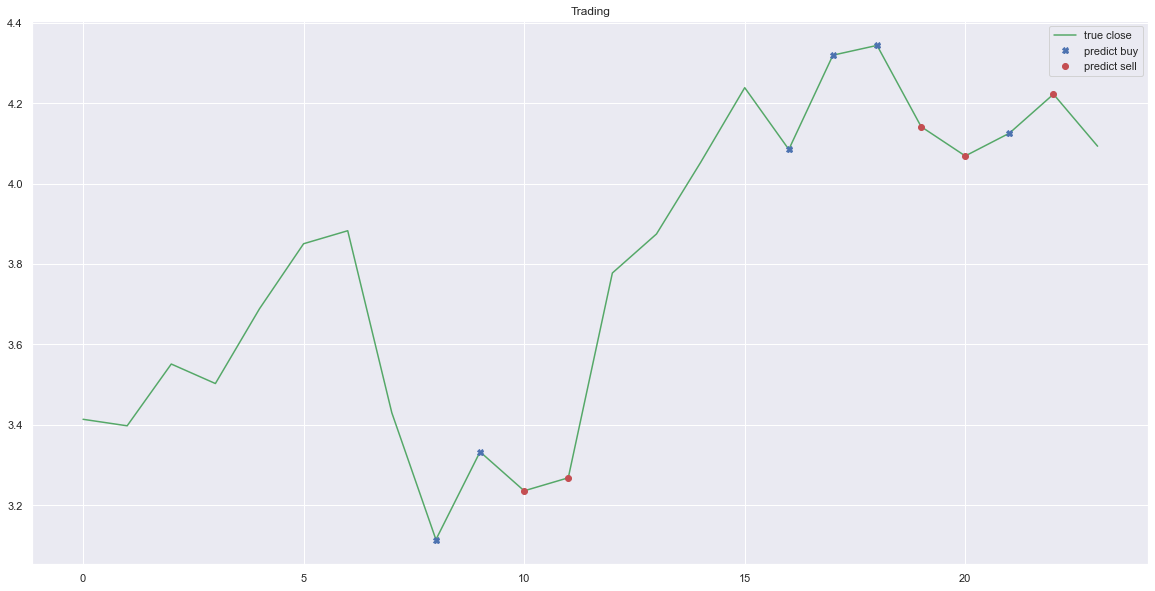

day 8: buy 5 units at price 15.570855, total balance 9984.429145
day 9: buy 0 units at price 0.000000, total balance 9984.429145
day 10, sell 5 units at price 16.177515, investment 3.896125 %, total balance 10000.606660,
day 16: buy 5 units at price 20.424110, total balance 9980.182550
day 17: buy 5 units at price 21.596980, total balance 9958.585570
day 18: buy 5 units at price 21.718315, total balance 9936.867255
day 19: buy 5 units at price 20.707215, total balance 9916.160040
day 20, sell 5 units at price 20.343220, investment -0.396052 %, total balance 9936.503260,
day 21: buy 5 units at price 20.626320, total balance 9915.876940
day 22, sell 5 units at price 21.111655, investment -2.247189 %, total balance 9936.988595,

total gained -63.011405, total investment -0.630114 %


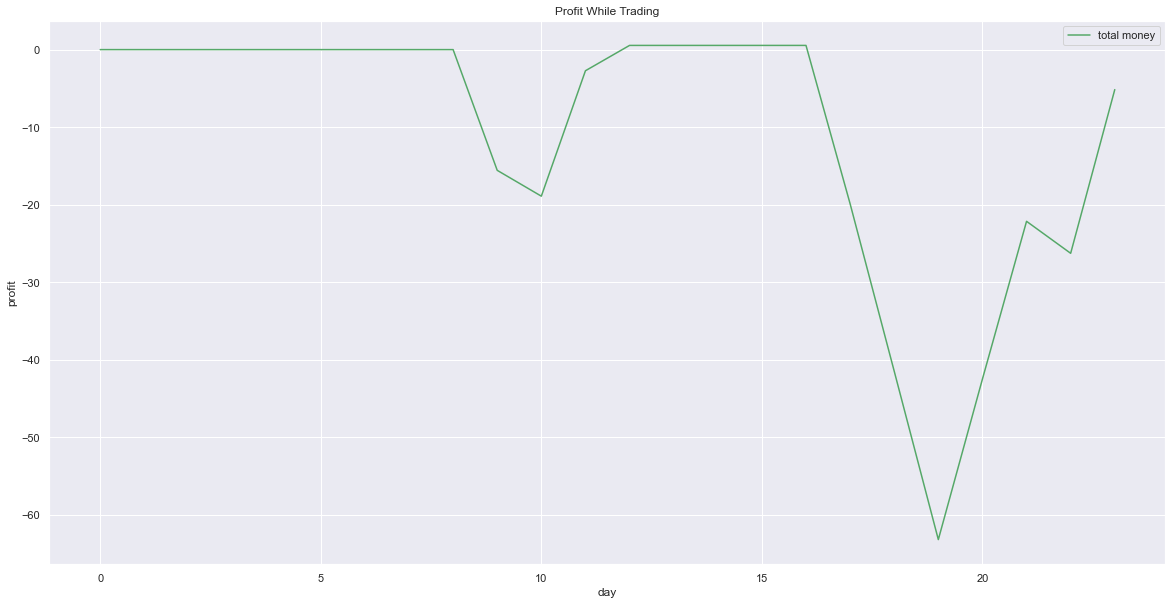

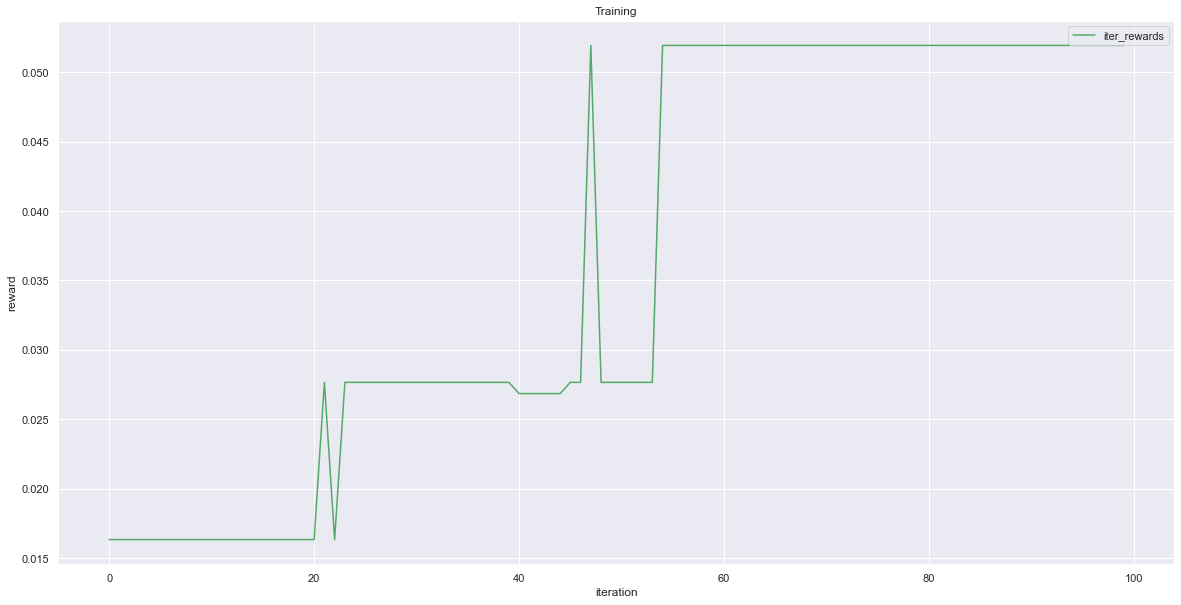

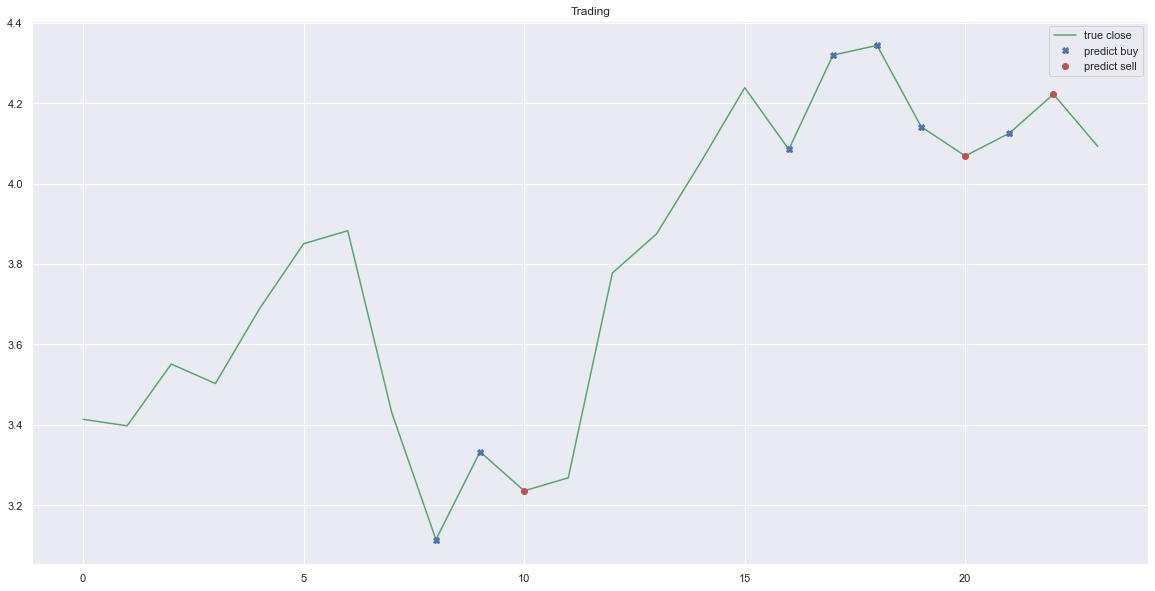

day 8: buy 5 units at price 15.570855, total balance 9984.429145
day 9: buy 1 units at price 3.332568, total balance 9981.096577
day 10: buy 0 units at price 0.000000, total balance 9981.096577
day 11, sell 5 units at price 16.339290, investment 4.935085 %, total balance 9997.435867,
day 12, sell 1 units at price 3.777450, investment 13.349525 %, total balance 10001.213317,
day 16: buy 5 units at price 20.424110, total balance 9980.789207
day 17: buy 5 units at price 21.596980, total balance 9959.192227
day 18: buy 5 units at price 21.718315, total balance 9937.473912
day 19: buy 5 units at price 20.707215, total balance 9916.766697
day 20, sell 5 units at price 20.343220, investment -0.396052 %, total balance 9937.109917,
day 21: buy 1 units at price 4.125264, total balance 9932.984653
day 22, sell 5 units at price 21.111655, investment -2.247189 %, total balance 9954.096308,

total gained -45.903692, total investment -0.459037 %


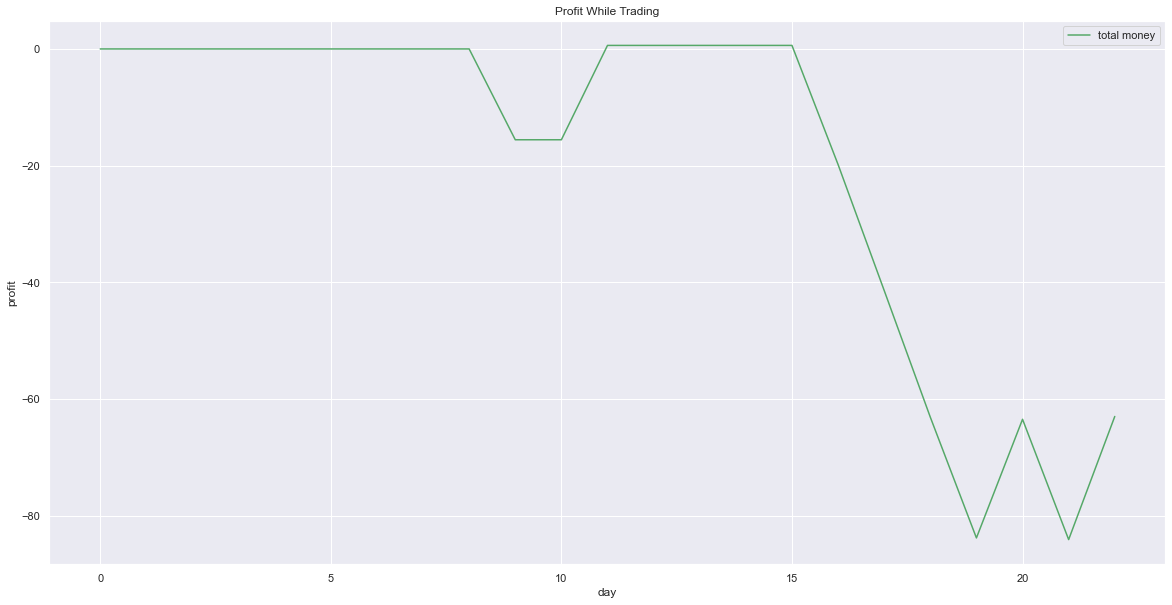

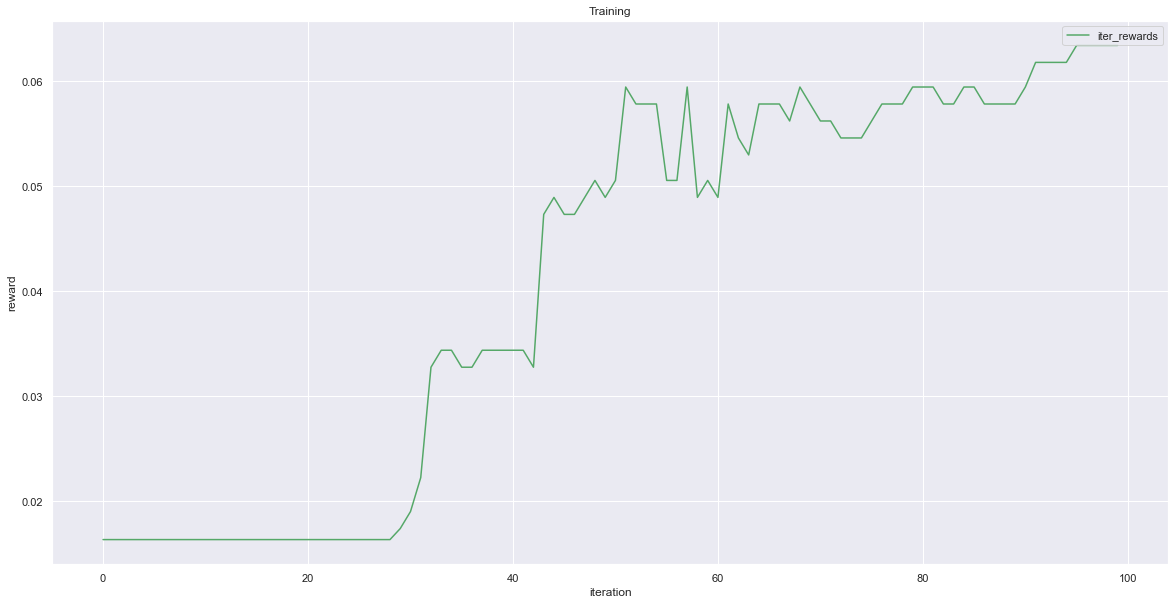

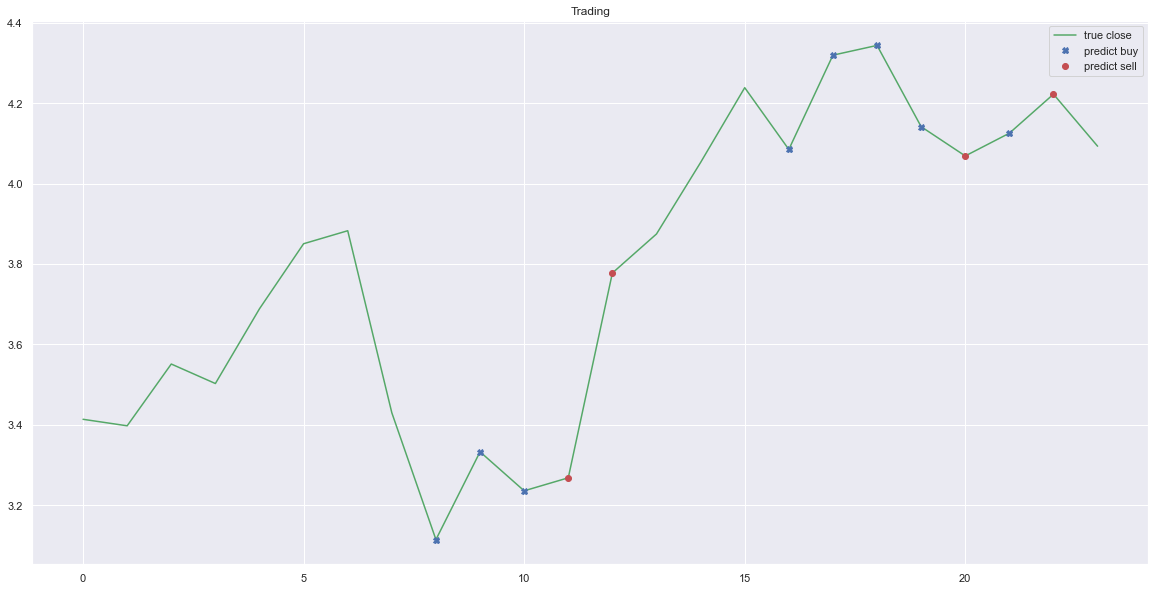

day 8: buy 5 units at price 15.570855, total balance 9984.429145
day 9: buy 1 units at price 3.332568, total balance 9981.096577
day 10, sell 5 units at price 16.177515, investment 3.896125 %, total balance 9997.274092,
day 11, sell 1 units at price 3.267858, investment -1.941746 %, total balance 10000.541950,
day 16: buy 5 units at price 20.424110, total balance 9980.117840
day 17: buy 5 units at price 21.596980, total balance 9958.520860
day 18: buy 5 units at price 21.718315, total balance 9936.802545
day 19, sell 5 units at price 20.707215, investment 1.386131 %, total balance 9957.509760,
day 20, sell 5 units at price 20.343220, investment -5.805256 %, total balance 9977.852980,
day 21: buy 1 units at price 4.125264, total balance 9973.727716
day 22, sell 5 units at price 21.111655, investment -2.793311 %, total balance 9994.839371,

total gained -5.160629, total investment -0.051606 %


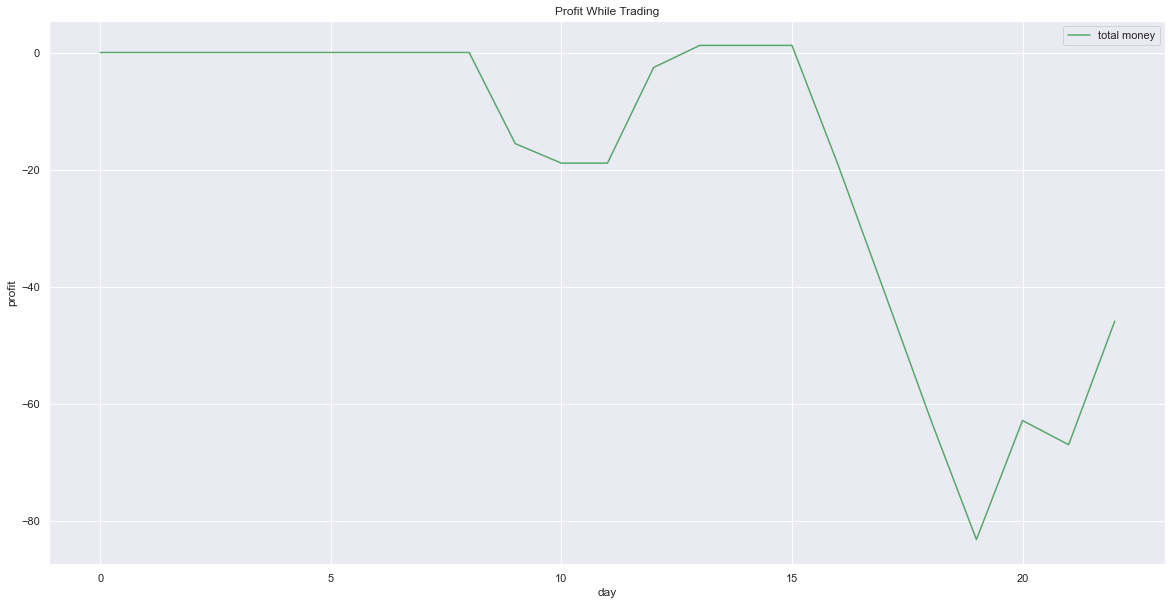

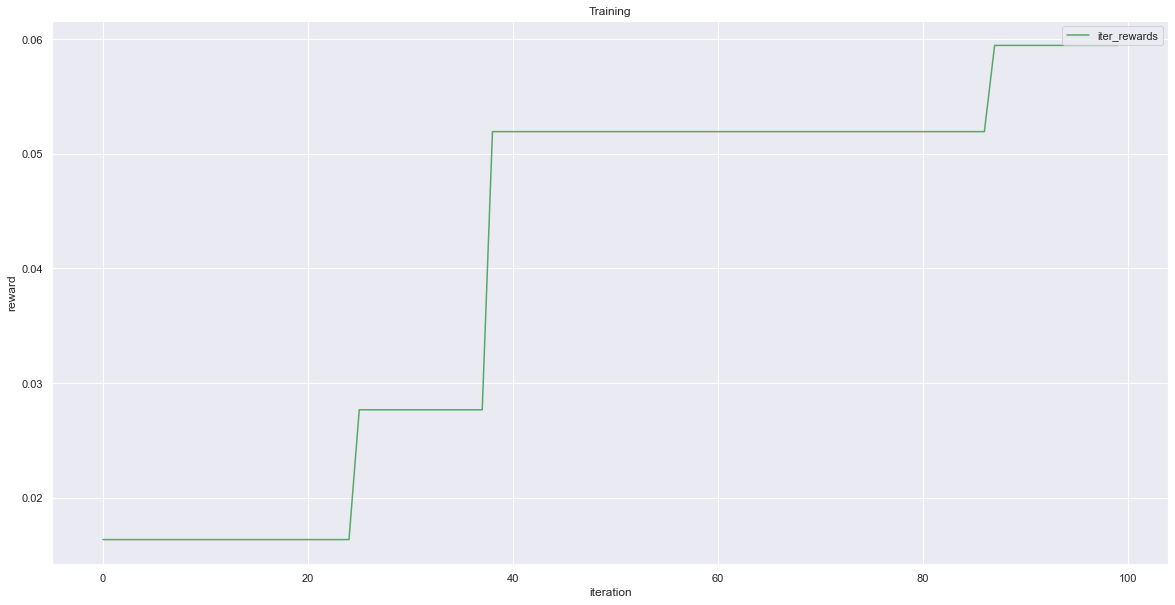

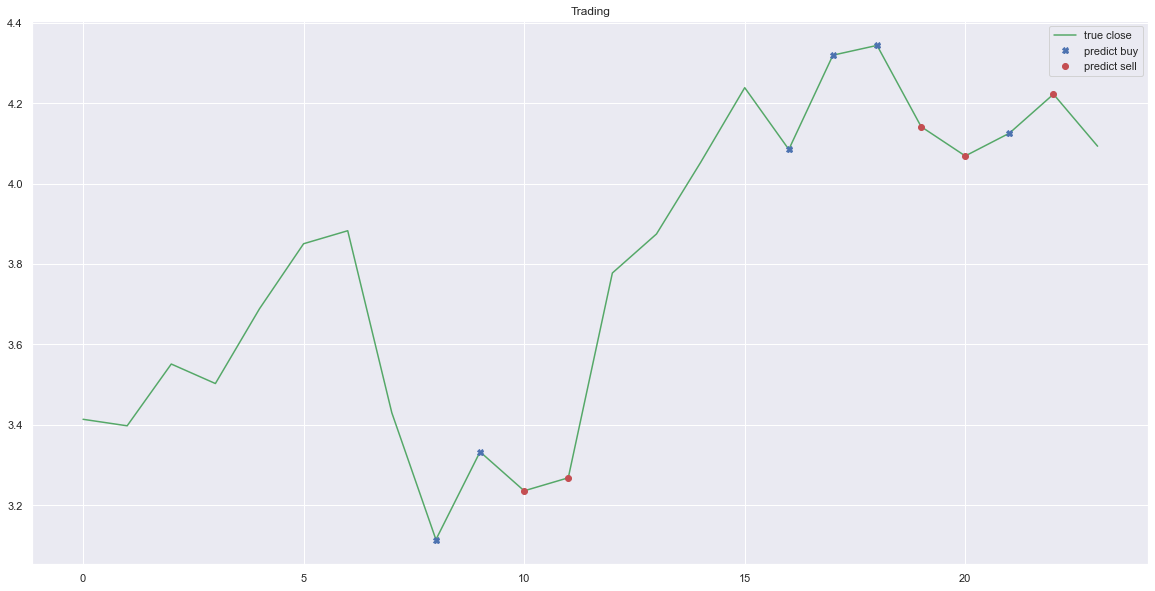

day 8: buy 5 units at price 15.570855, total balance 9984.429145
day 9: buy 1 units at price 3.332568, total balance 9981.096577
day 10: buy 0 units at price 0.000000, total balance 9981.096577
day 11, sell 5 units at price 16.339290, investment 4.935085 %, total balance 9997.435867,
day 12, sell 1 units at price 3.777450, investment 13.349525 %, total balance 10001.213317,
day 16: buy 5 units at price 20.424110, total balance 9980.789207
day 17: buy 5 units at price 21.596980, total balance 9959.192227
day 18: buy 5 units at price 21.718315, total balance 9937.473912
day 19, sell 5 units at price 20.707215, investment 1.386131 %, total balance 9958.181127,
day 20, sell 5 units at price 20.343220, investment -5.805256 %, total balance 9978.524347,
day 21: buy 1 units at price 4.125264, total balance 9974.399083
day 22, sell 5 units at price 21.111655, investment -2.793311 %, total balance 9995.510738,

total gained -4.489262, total investment -0.044893 %


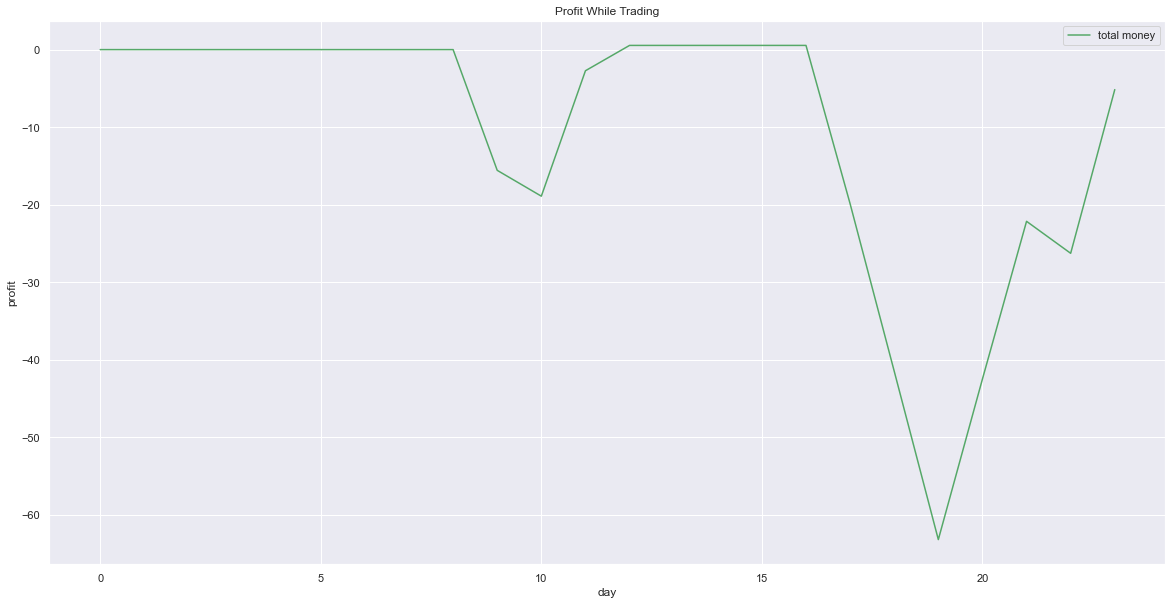

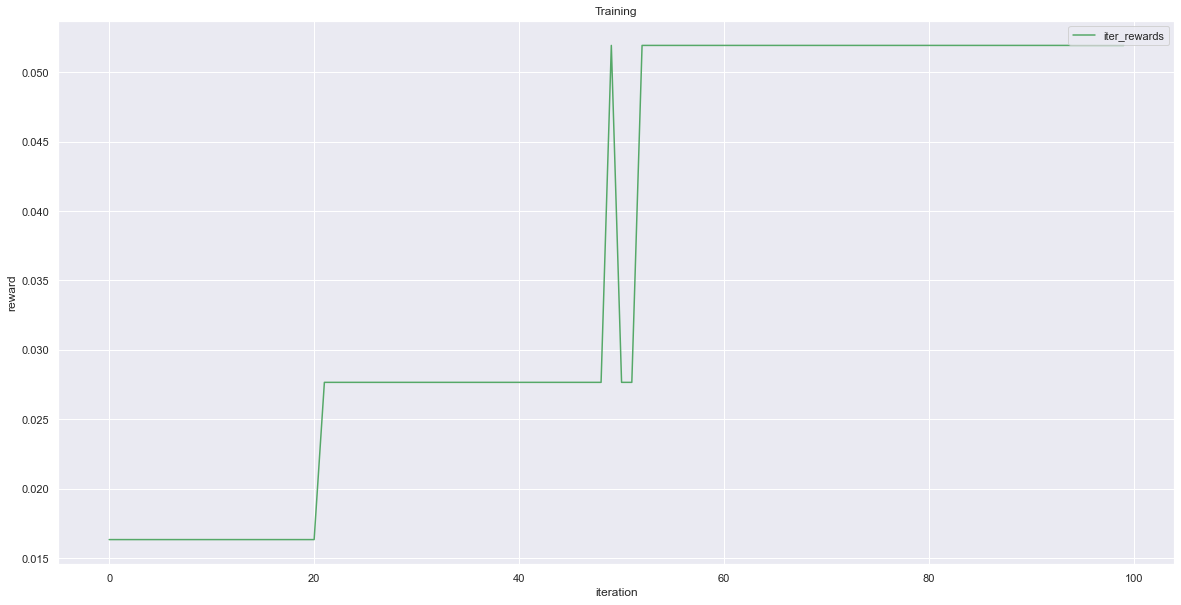

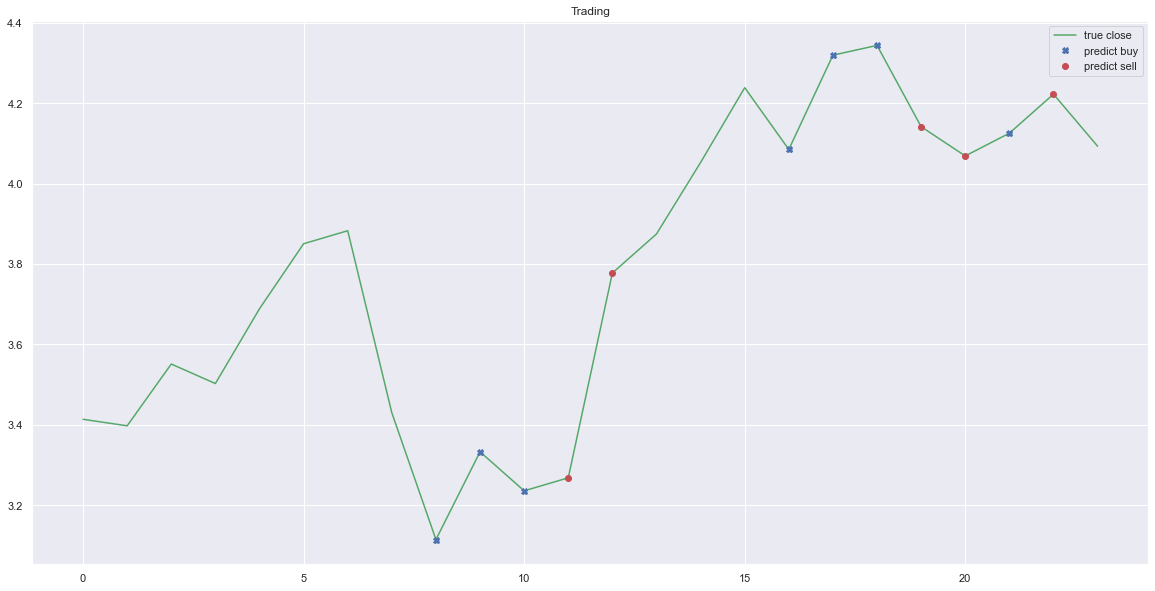

day 8: buy 5 units at price 15.570855, total balance 9984.429145
day 9: buy 1 units at price 3.332568, total balance 9981.096577
day 10: buy 4 units at price 12.942012, total balance 9968.154565
day 11, sell 5 units at price 16.339290, investment 4.935085 %, total balance 9984.493855,
day 12, sell 5 units at price 18.887250, investment 466.747625 %, total balance 10003.381105,
day 16: buy 5 units at price 20.424110, total balance 9982.956995
day 17: buy 5 units at price 21.596980, total balance 9961.360015
day 18: buy 5 units at price 21.718315, total balance 9939.641700
day 19: buy 5 units at price 20.707215, total balance 9918.934485
day 20, sell 5 units at price 20.343220, investment -0.396052 %, total balance 9939.277705,
day 21: buy 5 units at price 20.626320, total balance 9918.651385
day 22, sell 5 units at price 21.111655, investment -2.247189 %, total balance 9939.763040,

total gained -60.236960, total investment -0.602370 %


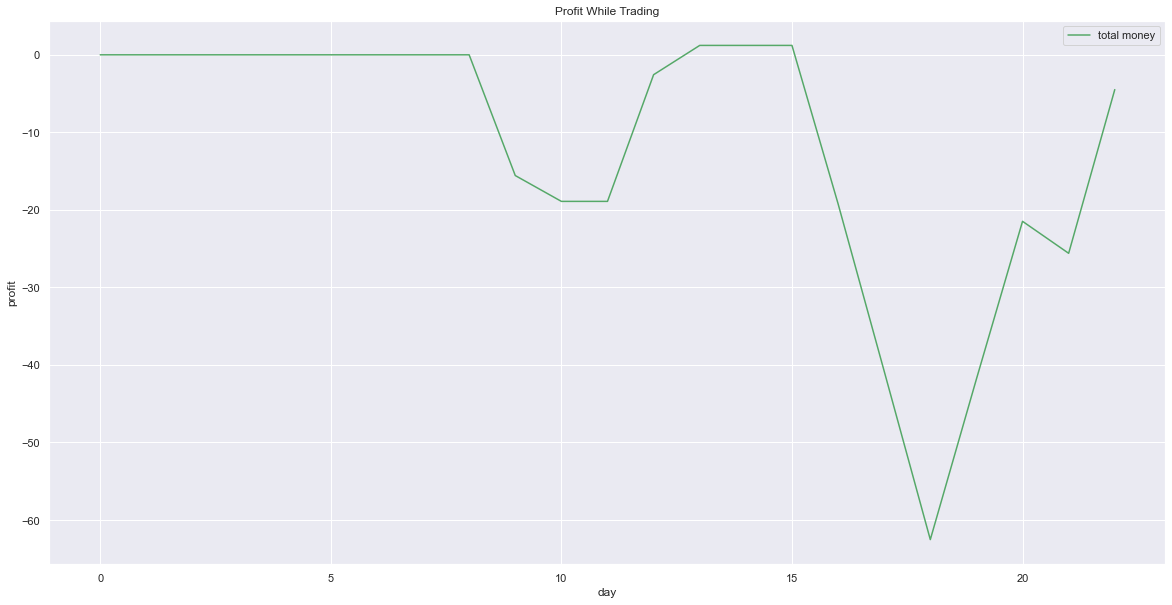

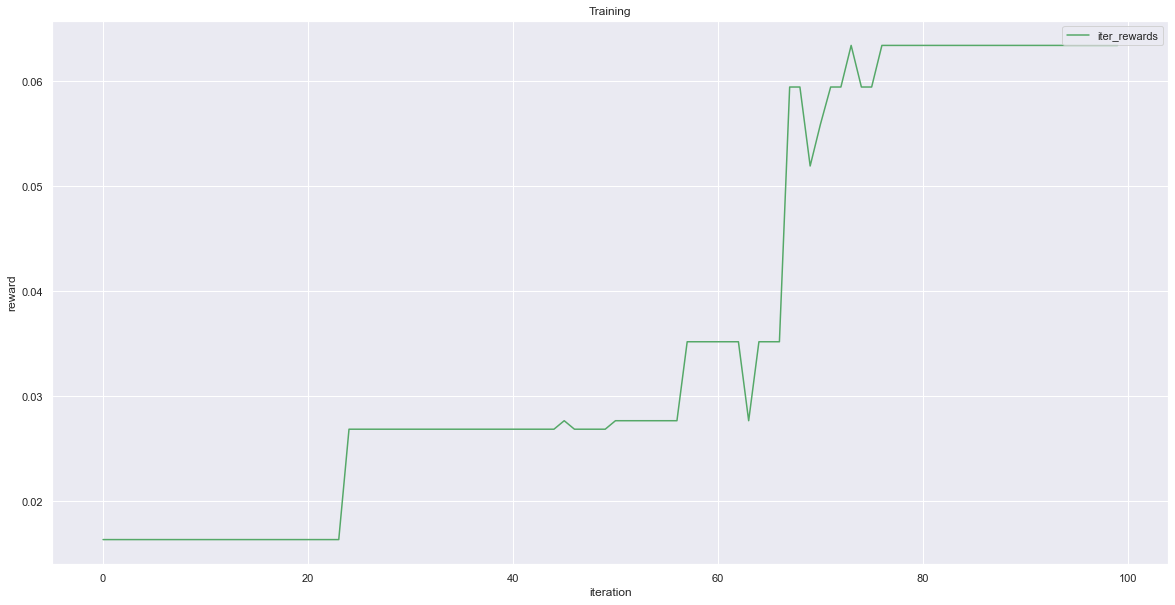

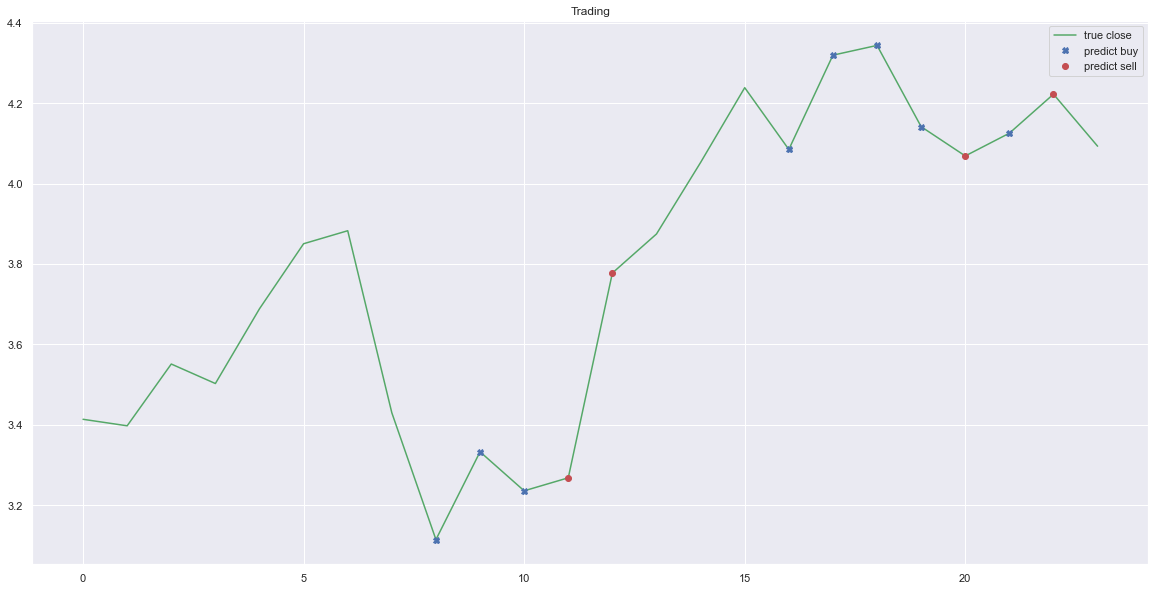

day 8: buy 5 units at price 15.570855, total balance 9984.429145
day 9: buy 1 units at price 3.332568, total balance 9981.096577
day 10, sell 5 units at price 16.177515, investment 3.896125 %, total balance 9997.274092,
day 11, sell 1 units at price 3.267858, investment -1.941746 %, total balance 10000.541950,
day 16: buy 5 units at price 20.424110, total balance 9980.117840
day 17: buy 5 units at price 21.596980, total balance 9958.520860
day 18: buy 5 units at price 21.718315, total balance 9936.802545
day 19: buy 5 units at price 20.707215, total balance 9916.095330
day 20, sell 5 units at price 20.343220, investment -0.396052 %, total balance 9936.438550,
day 21: buy 1 units at price 4.125264, total balance 9932.313286
day 22, sell 5 units at price 21.111655, investment -2.247189 %, total balance 9953.424941,

total gained -46.575059, total investment -0.465751 %


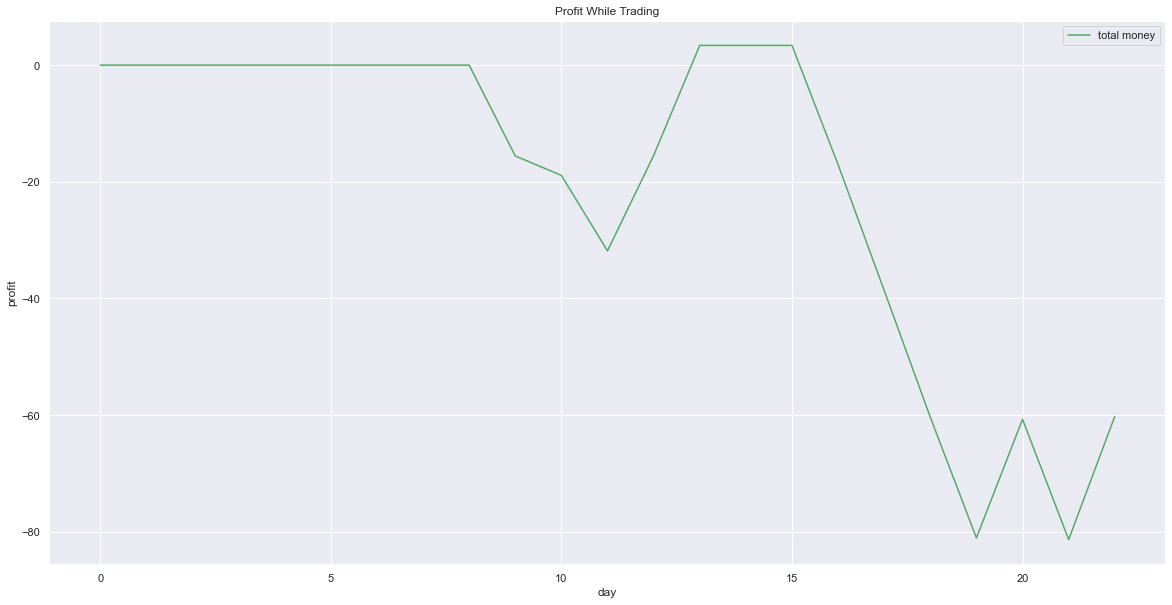

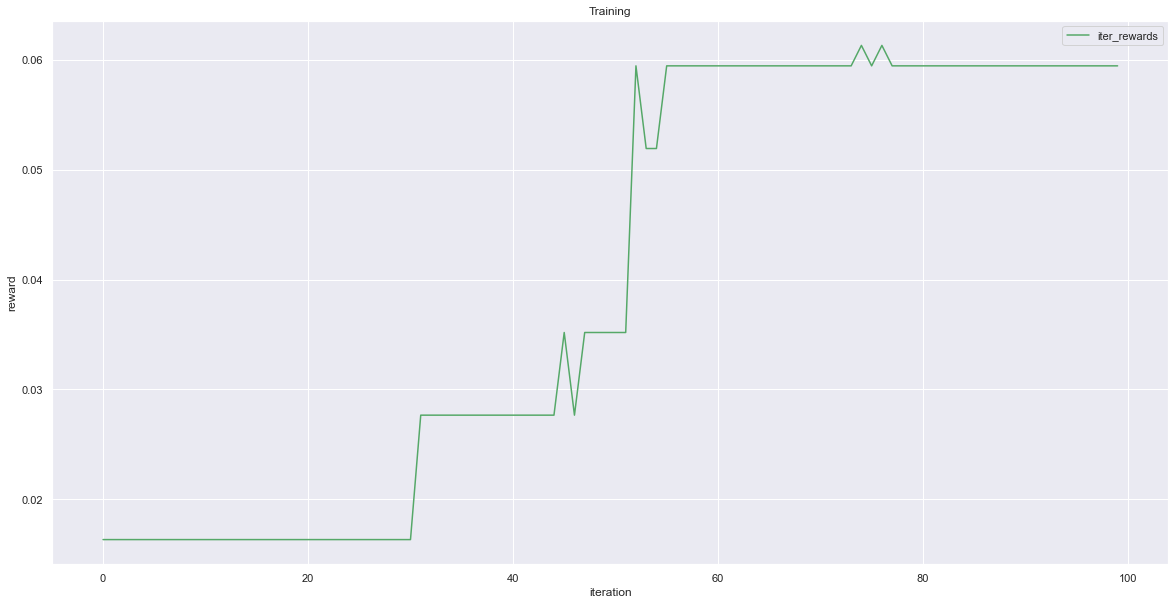

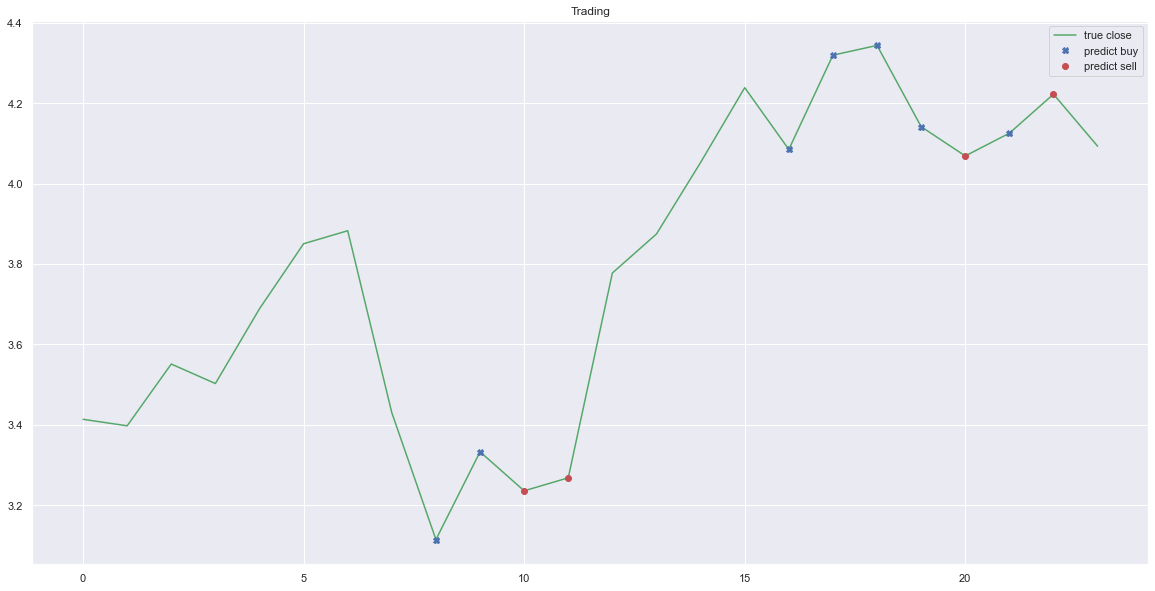

day 8: buy 5 units at price 15.570855, total balance 9984.429145
day 9: buy 1 units at price 3.332568, total balance 9981.096577
day 10: buy 0 units at price 0.000000, total balance 9981.096577
day 11, sell 5 units at price 16.339290, investment 4.935085 %, total balance 9997.435867,
day 12, sell 1 units at price 3.777450, investment 13.349525 %, total balance 10001.213317,
day 16: buy 5 units at price 20.424110, total balance 9980.789207
day 17: buy 5 units at price 21.596980, total balance 9959.192227
day 18: buy 5 units at price 21.718315, total balance 9937.473912
day 19: buy 5 units at price 20.707215, total balance 9916.766697
day 20, sell 5 units at price 20.343220, investment -0.396052 %, total balance 9937.109917,
day 21: buy 1 units at price 4.125264, total balance 9932.984653
day 22, sell 5 units at price 21.111655, investment -2.247189 %, total balance 9954.096308,

total gained -45.903692, total investment -0.459037 %


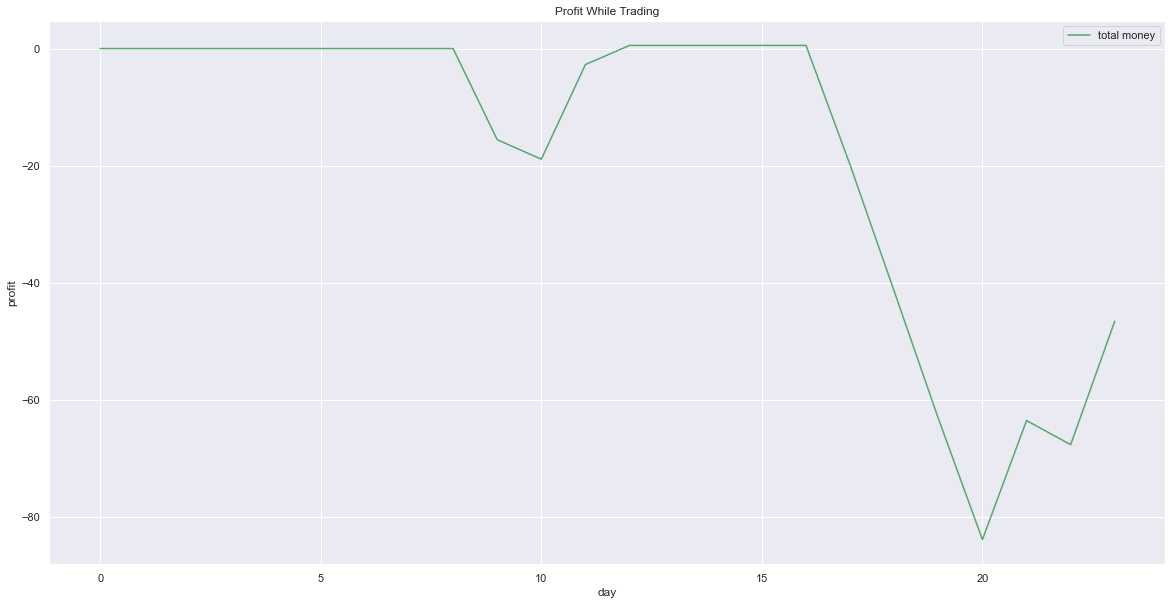

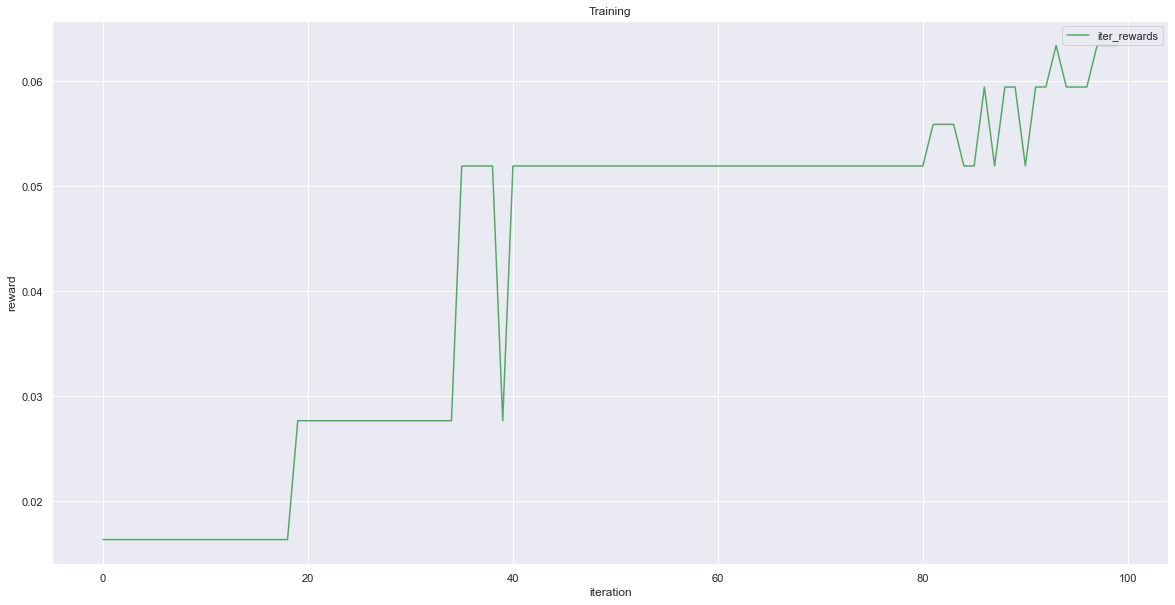

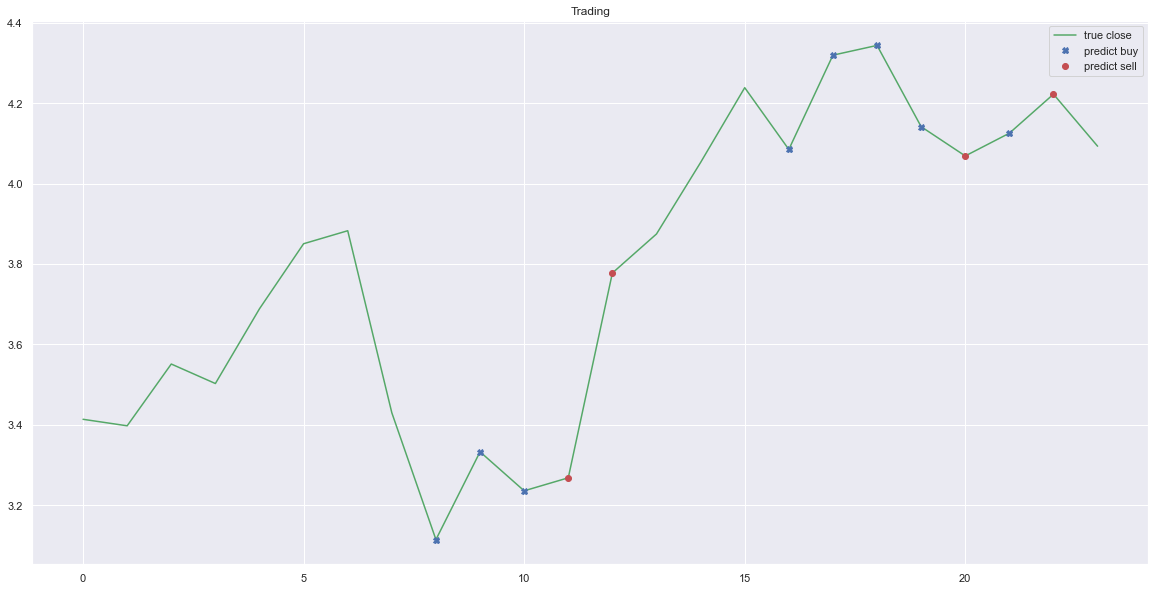

day 8: buy 5 units at price 15.570855, total balance 9984.429145
day 9: buy 1 units at price 3.332568, total balance 9981.096577
day 10: buy 1 units at price 3.235503, total balance 9977.861074
day 11, sell 5 units at price 16.339290, investment 4.935085 %, total balance 9994.200364,
day 12, sell 2 units at price 7.554900, investment 126.699050 %, total balance 10001.755264,
day 16: buy 5 units at price 20.424110, total balance 9981.331154
day 17: buy 5 units at price 21.596980, total balance 9959.734174
day 18: buy 5 units at price 21.718315, total balance 9938.015859
day 19: buy 5 units at price 20.707215, total balance 9917.308644
day 20, sell 5 units at price 20.343220, investment -0.396052 %, total balance 9937.651864,
day 21: buy 1 units at price 4.125264, total balance 9933.526600
day 22, sell 5 units at price 21.111655, investment -2.247189 %, total balance 9954.638255,

total gained -45.361745, total investment -0.453617 %


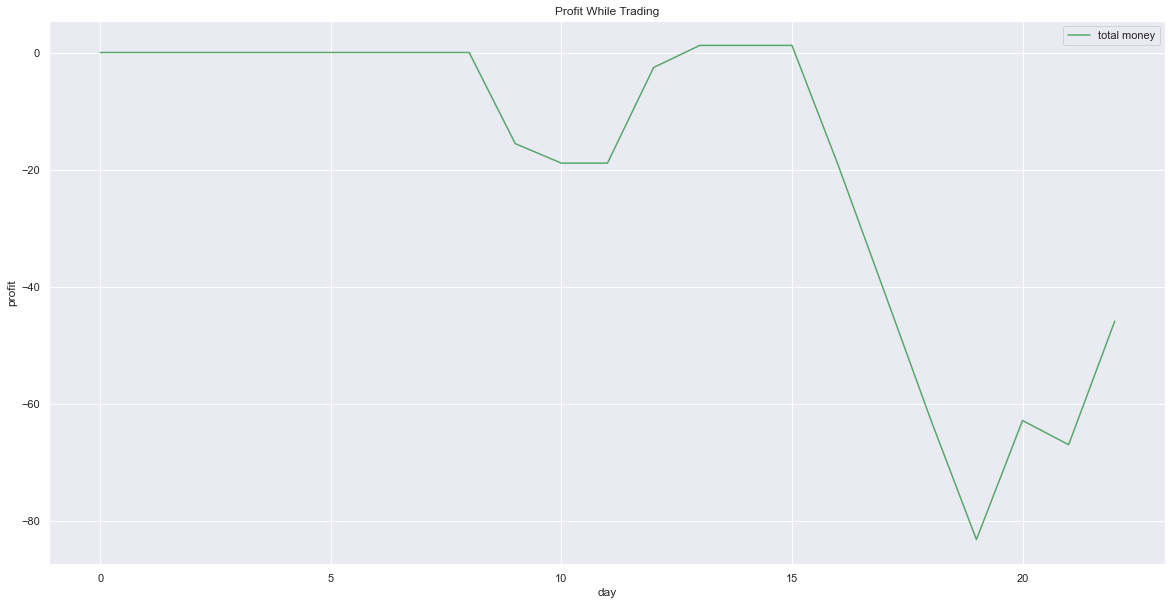

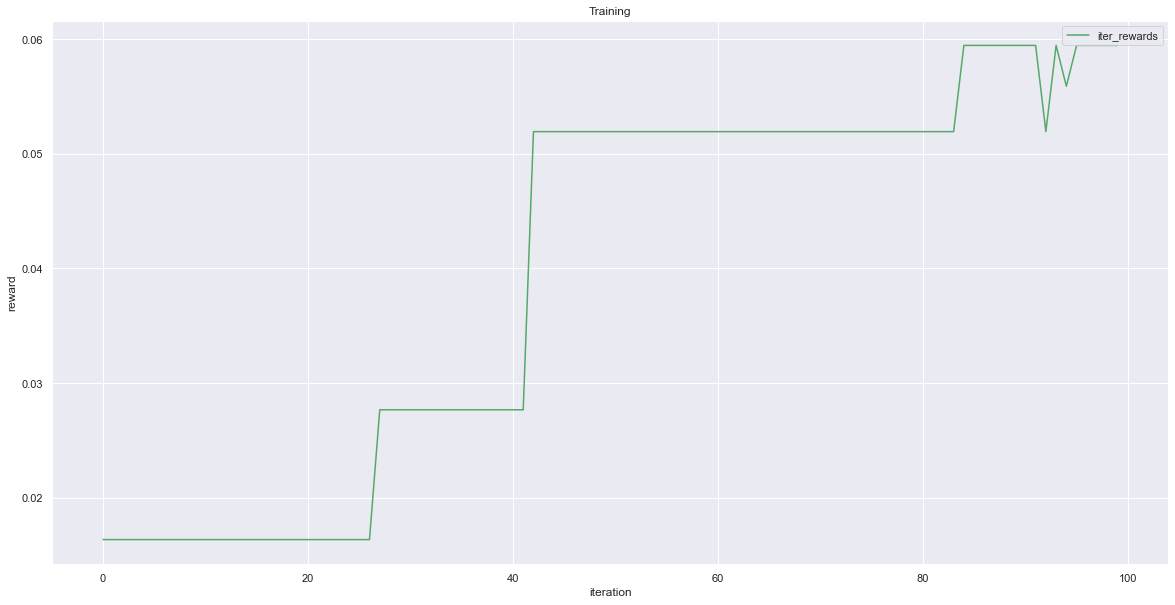

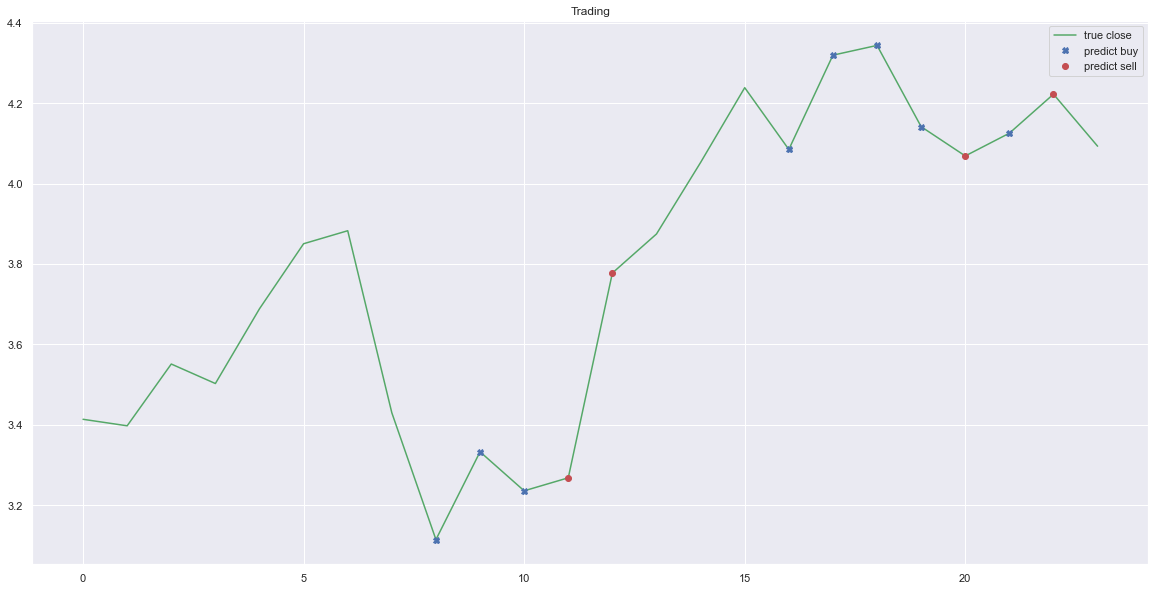

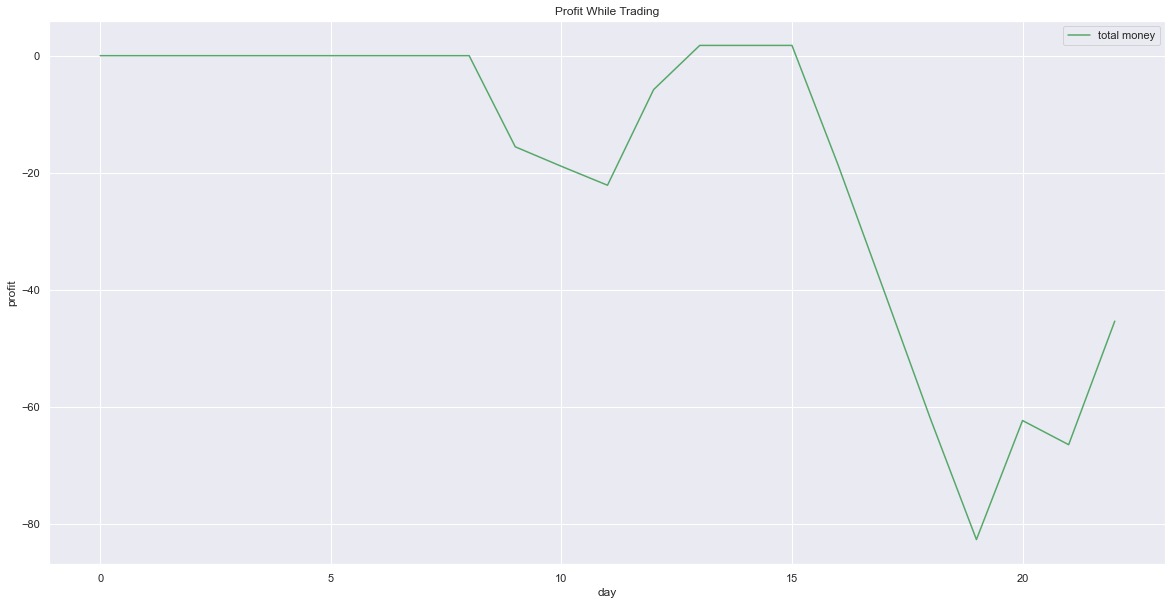

In [15]:
profits = []
labels = []

epoch_rewards = []
track_money = []

for i in range(0,sample_size):
    # Train
    close = t_train.Close.values.tolist()
    model.set_weights([feed_w1, decision_w2, buy_w3, feed_w4])
    agent = Agent(
        model = model,
        money = 10000,
        max_buy = 5,
        max_sell = 5,
        close = close,
        window_size = window_size,
        skip = 1,
    )
    agent.fit(iterations = num_iter_test, checkpoint = 10)       
    
    # Train plots
    plt.figure(figsize = (20, 10))
    plt.title("Training")
    plt.xlabel('iteration')
    plt.ylabel('reward')
    plt.plot(epoch_rewards, label = 'iter_rewards', c = 'g')
    plt.ticklabel_format(style='plain')
    plt.legend()
    saveFig(out_dir, 'train')
#     plt.show()
    writeCSV(out_dir, "train_data", epoch_rewards)
    epoch_rewards = []
    
    #Test
    close = t_test.Close.values.tolist()
    agent = Agent(
        model = model,
        money = 10000,
        max_buy = 5,
        max_sell = 5,
        close = close,
        window_size = window_size,
        skip = 1,
    )
    
    # Test trade (plots trading in agent.but())
    agent.buy()
    profit = agent.get_profit()
    profits.append(profit)
    
    # Profit plots
    plt.figure(figsize = (20, 10))
    plt.ticklabel_format(style='plain')
    plt.title("Profit While Trading")
    plt.xlabel('day')
    plt.ylabel('profit')
    plt.plot(track_money, label = 'total money', c = 'g')
    plt.legend()
    saveFig(out_dir, 'trade_balance')
#     plt.show()
    writeCSV(out_dir, "profit_data", track_money)
    
    track_money = []
    labels.append(str(i))

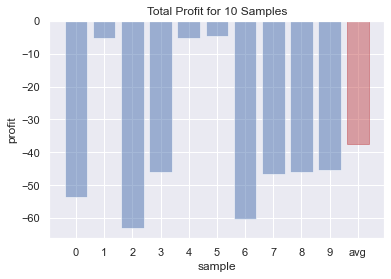

In [16]:
avg_profit = statistics.mean(profits) 
profits.append(avg_profit)
labels.append("avg")
y_pos = np.arange(len(profits))
plt.bar(y_pos, profits, align='center', alpha=0.5)[sample_size].set_color('r')
plt.xticks(y_pos, labels)
plt.ylabel('profit')
plt.xlabel('sample')
plt.title("Total Profit for " + str(len(profits) - 1) + " Samples")
saveFig(out_dir, 'results')
plt.show()
writeCSV(out_dir,"results_data",profits[:-1])